Детектор аномалии на принципе многократной прогонки реконструкции входного образца до сходимости латентного вектора.
Критерий аномальности - расстояние от первоначального латентного вектора до сошедшего.

In [84]:
from dataclasses import dataclass
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer, DefuzzyMaxLayer
import piqa
import sklearn.metrics as metrics
from sklearn.manifold import TSNE
from torchvision.transforms import v2
from torchinfo import summary
from matplotlib.colors import ListedColormap


In [85]:
batch_size = 256
learning_rate_ae = 1e-3
learning_rate_ad = 1e-3
num_epochs_ae = 15
num_epochs_ad = 30
latent_dim = 21
mnist_class_anomaly = 4
kernels = 8
fuzzy_rules_count = 16
beta = 1e-1

prefix = f"fuzzy_ad"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

binary_cmap = ListedColormap(['yellow', 'red'], N=2)
ssim = piqa.SSIM(window_size = 11, n_channels=1, reduction='none').to(device)
device

device(type='cuda')

## Датасет

1. Исключаем класс аномалии `mnist_class_anomaly` из общей выборк
2. Убираем метки с остальных классов
   

In [86]:
def norm_and_transform(x):
    nimg = x.view(-1, 28, 28)
    nimg = torch.clamp(nimg, 0, 1)
    return nimg

def clamp(x):
    #nimg = 2.0*(x.view(-1, 28, 28) - 0.5)
    nimg = torch.clamp(x, 0, 1)
    return nimg

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(norm_and_transform)
])

augmentation = transforms.Compose([
    transforms.RandomRotation(15, fill=0), 
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), fill=0), 
    #transforms.RandomCrop(size=26),
    #transforms.Resize(size=(28, 28)),
    transforms.Lambda(clamp)
])

In [87]:
def get_target_and_mask(target_label):
    t = target_label
    return t 

train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)

idx = (train_data.targets != mnist_class_anomaly)
train_data.targets = train_data.targets[idx]
train_data.data = train_data.data[idx]
len(train_data)

54158

загружаем тестовую выборку

In [88]:
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

Создаем итераторы датасетов

In [89]:

train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

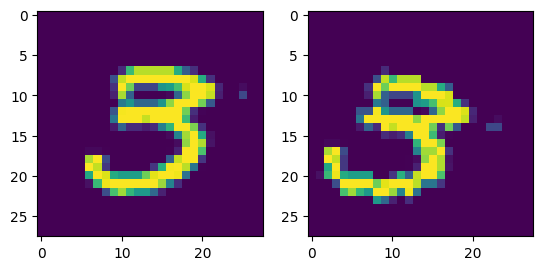

In [90]:
for data,_ in iter(train_loader):
    R, C = 1, 2
    plt.subplot(R, C, 1)
    plt.imshow(data[0].squeeze())
    plt.subplot(R, C, 2)
    plt.imshow(augmentation(data)[0].squeeze())
    
    
    break

## Модель

In [91]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim, kernels):
        super(Encoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv2d(1, kernels, kernel_size = 5), 
            nn.Conv2d(kernels, kernels, kernel_size = 5), 
            nn.BatchNorm2d(kernels), 
            nn.SiLU(),

            nn.Conv2d(kernels, 2*kernels, kernel_size = 5), 
            nn.Conv2d(2*kernels, 2*kernels, kernel_size = 5), 
            nn.BatchNorm2d(2*kernels), 
            nn.SiLU(),

            nn.Conv2d(2*kernels, 4*kernels, kernel_size = 5), 
            nn.Conv2d(4*kernels, 4*kernels, kernel_size = 5), 
            nn.BatchNorm2d(4*kernels), 
            nn.SiLU(),

            nn.Conv2d(4*kernels, 8*kernels, kernel_size = 4), 
            nn.BatchNorm2d(8*kernels), 
            nn.SiLU(),            
        )

        self.latent = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*kernels, 2 * latent_dim)
        )
        self.softplus = nn.Softplus()
        

    def forward(self, x, eps: float = 1e-8):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """
        x = self.encoder(x)
        x = self.latent(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        dist = torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        z = dist.rsample()

        return mu, logvar, z

#inp = torch.rand(10, 1, 28, 28)
#m = Encoder(latent_dim, 16)
#fz, mu, dfz = m.forward(inp)

#summary(m, input_size=(batch_size, 1, 28, 28))


In [92]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim, kernels):
        super(Decoder, self).__init__()

        self.decode = nn.Sequential(
            nn.Linear(latent_dim, 8*kernels),
            nn.BatchNorm1d(8*kernels),
            nn.Unflatten(1, (8*kernels, 1, 1)),
            
            nn.ConvTranspose2d(8*kernels, 4*kernels, 4),
            nn.BatchNorm2d(4*kernels),
            nn.SiLU(),

            nn.ConvTranspose2d(4*kernels, 2*kernels, 5),
            nn.ConvTranspose2d(2*kernels, 2*kernels, 5),
            nn.BatchNorm2d(2*kernels),
            nn.SiLU(),

            nn.ConvTranspose2d(2*kernels, kernels, 5),
            nn.ConvTranspose2d(kernels, kernels, 5),
            nn.BatchNorm2d(kernels),
            nn.SiLU(),

            nn.ConvTranspose2d(kernels, kernels, 5),
            nn.ConvTranspose2d(kernels, 1, 5),
            nn.BatchNorm2d(1),
            nn.SiLU(),
        )
        
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """
        out = self.decode(z)
        out = out.clamp(0, 1)
        return out
    
    
# inp = torch.rand(batch_size, latent_dim)
#m = Decoder(latent_dim, 16)
# mu = m.forward(inp)
# mu[0].shape

#summary(m, input_size=(batch_size, latent_dim))

In [93]:
class VAEFuzzyCFR(nn.Module):
    """
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    def __init__(self, latent_dim, fuzzy_rules_count, kernels):
        super(VAEFuzzyCFR, self).__init__()

        self.encoder = Encoder(latent_dim, kernels)        
        self.decoder = Decoder(latent_dim, kernels)

        initial_centroids = 1 * np.random.rand(fuzzy_rules_count, latent_dim)
        initial_scales = 1 * np.ones((fuzzy_rules_count, latent_dim))
        self.fuzzy = nn.Sequential(
             FuzzyLayer.from_centers_and_scales(initial_centroids, initial_scales, trainable=True)
             #DefuzzyLinearLayer.from_dimensions(fuzzy_rules_count, 10, with_norm=False)
        )
        
    def forward(self, x):
        """
        
        """
        mu, logvar, z = self.encoder(x)
        x_recon = self.decoder(mu)
        fz = self.fuzzy(mu)
        
        return mu, logvar, z, fz, x_recon
    
    def half_pass(self, x):
        mu, logvar, z = self.encoder(x)
        return mu, logvar, z
    
    def decoder_pass(self, x):
        r = self.decoder(x)
        return r
    
    def fuzzy_pass(self, x):
        fz = self.fuzzy(x)
        return fz

In [94]:
fvae = VAEFuzzyCFR(latent_dim=latent_dim, fuzzy_rules_count=fuzzy_rules_count, kernels=kernels).to(device)

num_params = sum(p.numel() for p in fvae.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

summary(fvae, input_size=(batch_size, 1, 28, 28))

Number of parameters: 150,053


Layer (type:depth-idx)                   Output Shape              Param #
VAEFuzzyCFR                              [256, 21]                 --
├─Encoder: 1-1                           [256, 21]                 --
│    └─Sequential: 2-1                   [256, 64, 1, 1]           --
│    │    └─Conv2d: 3-1                  [256, 8, 24, 24]          208
│    │    └─Conv2d: 3-2                  [256, 8, 20, 20]          1,608
│    │    └─BatchNorm2d: 3-3             [256, 8, 20, 20]          16
│    │    └─SiLU: 3-4                    [256, 8, 20, 20]          --
│    │    └─Conv2d: 3-5                  [256, 16, 16, 16]         3,216
│    │    └─Conv2d: 3-6                  [256, 16, 12, 12]         6,416
│    │    └─BatchNorm2d: 3-7             [256, 16, 12, 12]         32
│    │    └─SiLU: 3-8                    [256, 16, 12, 12]         --
│    │    └─Conv2d: 3-9                  [256, 32, 8, 8]           12,832
│    │    └─Conv2d: 3-10                 [256, 32, 4, 4]           25,6

## Losses

In [95]:
def compute_vae_loss(x, recon_x, mu, logvar):
    
    diff = ssim(x, recon_x)
    
    loss_recon = (1 - diff).square().mean() #F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()#
    
    tsquare = torch.square(mu)
    tlogvar = torch.exp(logvar)
    kl_loss = -0.5 * (1 + logvar - tsquare - tlogvar)
    loss_kl = kl_loss.sum(-1).mean()
    
    loss = loss_recon + beta * loss_kl

    return loss, loss_recon, loss_kl

In [96]:
def compute_cfr_loss(fz, utilities):
    #inp_batch_size = imgs.shape[0]

    #rimgs = imgs.repeat_interleave(fuzzy_rules_count, dim=0)
    #rdfz = raw_inferences.repeat(inp_batch_size, 1, 1, 1)

    #pos_util = ssim(x, x_rec).reshape(-1, 1)
    #utilities = torch.cat((pos_util, 2*(1 - pos_util)), dim = 1)#ssim(rdfz, rimgs).reshape(-1, fuzzy_rules_count)

    fz_util_tmp = (fz * utilities).sum(-1)
    fz_sum = fz.sum(-1)

    u_x = torch.where(fz_sum.abs() > 1e-20, fz_util_tmp/fz_sum, fz_util_tmp).reshape(-1, 1)

    regret = utilities - u_x
    zeros = torch.zeros_like(regret)
    regret = torch.maximum(regret, zeros)
    regret_sum = regret.sum(-1).reshape(-1, 1).repeat(1, fuzzy_rules_count)
    fz_upd = torch.where(regret_sum > 0, regret/regret_sum, 1/fuzzy_rules_count)
    
    fz_upd = fz_upd.detach()
    loss_fz = (fz_upd - fz).square().sum(-1).mean()
    
    return loss_fz

In [97]:
def keep_eigenvals_positive_loss(layer, eps = 1e-10):
    ev = layer.get_transformation_matrix_eigenvals().real.min()
    ev = torch.clamp(ev, max=eps)
    return -ev

In [98]:
def fuzzy_term_volume_loss(layer):
    ev = layer.get_transformation_matrix_eigenvals().real.mean(-1)
    ev = 1/ev.mean()
    return ev

In [99]:
# def compute_grad(model, sample):
#     sample = sample.unsqueeze(0)  # prepend batch dimension for processing
    
#     mu, logvar, z, fz, x_recon = model(sample)
#     loss = (1 - fz.sum(-1)).square().sum()

#     return torch.autograd.grad(loss, list(model.encoder.parameters()))


# def compute_sample_grads(model, data):
#     inp_batch_size = data.shape[0]
#     if inp_batch_size <= 0:
#         return []
#     sample_grads = [ sum(a.square().sum().item() for a in compute_grad(model, data[i])) for i in range(inp_batch_size) ]
#     #sample_grads = zip(*sample_grads)
#     #sample_grads = [torch.stack(shards) for shards in sample_grads]
#     return sample_grads

def get_arate(model, imgs):
    mu, _, _ = model.half_pass(imgs)  
    fzc = model.fuzzy[0].get_centroids()
    
    return torch.cdist(mu, fzc).min(-1).values.detach().cpu().numpy() #compute_sample_grads(model, imgs)#fz[:, 1].cpu().numpy() ##(1 - ssim(x_recon.clamp(0, 1), inp)).cpu().numpy()#xent_continuous_ber((x_recon + 1)/2, (inp + 1)/2).cpu().numpy()# #ssim((inp + 1)/2, (recon_x+1)/2).cpu().numpy() #fz.sum(-1).cpu().numpy()#

# fvae.eval()
# #data = torch.rand(batch_size, 1, 28, 28).to(device).detach()

# for batch_idx, (data, lab) in enumerate(tqdm(test_loader, disable=True)):
#     #data = data.view((-1,1,28,28)).to(device)
#     data = data.to(device)
#     print(lab.shape)
#     print(compute_sample_grads(fvae, data))
#     break

## Train AE

In [100]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def train(model, dataloader, optimizer, sched, prev_updates, epoch, writer=None):
    model.train()  
    
    for batch_idx, (data, _) in enumerate(tqdm(dataloader, disable=True)):
        data = data.to(device)
        adata = augmentation(data)
        
        optimizer.zero_grad()  
        
        mu, logvar, z = model.half_pass(adata)  
        recon_x = model.decoder_pass(z)
        fz = model.fuzzy_pass(mu)
        
        loss, _, _ = compute_vae_loss(data, recon_x, mu, logvar)
        loss_fz = (0.5-fz).abs().min(-1).values.mean()
        
        ev_loss = keep_eigenvals_positive_loss(model.fuzzy[0])
        if ev_loss.item() > 0:
            print("ev singularity")
            ev_loss.backward(retain_graph=True)

        (loss + 1e-1 * loss_fz).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-2)
        optimizer.step()  

        if sched is not None:
            sched.step()
        
    if writer is not None:
        writer.add_scalar('FAD/LR', get_lr(optimizer), global_step=epoch)
        
    return prev_updates + len(dataloader)

In [101]:
#fixed_random_z = torch.randn(16, fuzzy_rules_count).to(device)

def test(model, dataloader, cur_step, epoch, writer=None):
    model.eval() 

    test_recon_loss = 0
    test_fz_vol = 0
    test_fz_sum = 0
    test_fz_cfr_loss = 0
    
    lab_true = []
    lab_pred = []

    #with torch.no_grad():
    for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
        data = data.to(device)
        rates = get_arate(model, data)
        
        for f, l in  zip(rates, lab):
            lab_pred.append(f)        
            if l == mnist_class_anomaly:
                lab_true.append(1)
            else:
                lab_true.append(0)
                    
    fpr, tpr, _ = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    embedings = []
    labels_expected = []
    
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing', disable=True):
            data = data.to(device)

            mu, logvar, _ = model.half_pass(data)  
            recon_x = model.decoder_pass(mu)
            fz = model.fuzzy_pass(mu)

            embedings.append(mu.cpu().numpy())
            labels_expected.append((target == mnist_class_anomaly).cpu().numpy())

            _, loss_recon, _ = compute_vae_loss(data, recon_x, mu, logvar)
            
            #centroids = model.fuzzy[0].get_centroids().detach()
            #centroids_imgs = model.decoder_pass(centroids)
            loss_cfr = torch.zeros(1) # compute_cfr_loss(data, recon_x, fz)
            fz_vol = fuzzy_term_volume_loss(model.fuzzy[0])
            fz_sum = fz.sum(-1).mean()
            
            test_recon_loss += loss_recon.item()
            test_fz_vol += fz_vol.item()
            test_fz_sum += fz_sum.item()
            test_fz_cfr_loss += loss_cfr.item()
            

    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)
   
    test_recon_loss /= len(dataloader)
    test_fz_vol /= len(dataloader)
    test_fz_sum /= len(dataloader)
    test_fz_cfr_loss /= len(dataloader)
    
    print(f'[{cur_step}] Reconstruction loss: {test_recon_loss:.4f}, VOL: {test_fz_vol:.4f} SUM: {test_fz_sum:.2f} AUC: {roc_auc:.4f}')
    
    if writer is not None:
        writer.add_scalar('FAD/AUC', roc_auc, global_step=cur_step)
        writer.add_scalar('FAD/Reconstruction', test_recon_loss, global_step=cur_step)
        writer.add_scalar('FAD/Volume', test_fz_vol, global_step=cur_step)
        writer.add_scalar('FAD/Sum', test_fz_sum, global_step=cur_step)
        writer.add_scalar('FAD/CFR', test_fz_cfr_loss, global_step=cur_step)
        
        fig, ax = plt.subplots(1, 2, figsize=(9, 4))
        centroids_c = model.fuzzy[0].get_centroids().detach().cpu().numpy()
        
        ax[0].scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap=binary_cmap, s=2)
        ax[0].scatter(centroids_c[:, 0],      centroids_c[:, 1], marker='1', c='green', s= 50)
        
        #ax[0].set_xlim(-1, 1)
        #ax[0].set_ylim(-1, 1)
        
        ax[1].scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap=binary_cmap, s=2)
        ax[1].scatter(centroids_c[:, 0],      centroids_c[:, 2], marker='1', c='green', s= 50)
        
        #ax[1].set_xlim(-1, 1)
        #ax[1].set_ylim(-1, 1)
        
        #act_fz = torch.diag(torch.ones(fuzzy_rules_count)).to(device)
        samples = model.decoder_pass(model.fuzzy[0].get_centroids().detach())
        img_idx = 0
        fign, axn = plt.subplots(8, 1 + fuzzy_rules_count//8, figsize=(1 + fuzzy_rules_count//8, 8), squeeze=False)
        for i in range(8):
            if img_idx >= fuzzy_rules_count:
                continue
            for j in range(fuzzy_rules_count//8):
                axn[i, j].imshow(samples[img_idx].view(28, 28).cpu().detach().numpy(), cmap='gray')
                axn[i, j].axis('off')
                img_idx += 1

        writer.add_figure('FAD/Emedding', fig, global_step=cur_step)
        writer.add_figure('FAD/Samples', fign, global_step=cur_step)

In [102]:
prev_updates = 0
optimizer_ae = torch.optim.Adam(fvae.parameters(), lr=learning_rate_ae)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer_ae, learning_rate_ae, epochs=num_epochs_ae, steps_per_epoch=len(train_loader))
#sched = torch.optim.lr_scheduler.ConstantLR(optimizer_ae, learning_rate_ae)

In [103]:
for epoch in range(num_epochs_ae):
    prev_updates = train(fvae, train_loader, optimizer_ae, sched, prev_updates, epoch, writer=writer)
    test(fvae, test_loader, prev_updates, epoch, writer=writer)
    #scheduler.step()

[212] Reconstruction loss: 0.7356, VOL: 1.0006 SUM: 1.30 AUC: 0.4187
ev singularity
[424] Reconstruction loss: 0.5586, VOL: 0.9998 SUM: 1.65 AUC: 0.4010
ev singularity
[636] Reconstruction loss: 0.5075, VOL: 0.9962 SUM: 1.87 AUC: 0.3485
[848] Reconstruction loss: 0.4630, VOL: 0.9942 SUM: 1.80 AUC: 0.2673
[1060] Reconstruction loss: 0.4140, VOL: 0.9954 SUM: 1.72 AUC: 0.4871
[1272] Reconstruction loss: 0.3814, VOL: 0.9968 SUM: 1.77 AUC: 0.3835
[1484] Reconstruction loss: 0.3856, VOL: 0.9969 SUM: 1.79 AUC: 0.4098
[1696] Reconstruction loss: 0.3882, VOL: 0.9976 SUM: 1.79 AUC: 0.3087
ev singularity
[1908] Reconstruction loss: 0.3283, VOL: 0.9976 SUM: 1.72 AUC: 0.2556
[2120] Reconstruction loss: 0.3241, VOL: 0.9987 SUM: 1.68 AUC: 0.2797
[2332] Reconstruction loss: 0.3135, VOL: 0.9999 SUM: 1.66 AUC: 0.2533
[2544] Reconstruction loss: 0.2959, VOL: 1.0003 SUM: 1.71 AUC: 0.2540
[2756] Reconstruction loss: 0.2912, VOL: 1.0005 SUM: 1.66 AUC: 0.2657
[2968] Reconstruction loss: 0.2903, VOL: 1.0005 S

## Train AD

In [104]:
фыва

NameError: name 'фыва' is not defined

In [ ]:
params = list(fvae.fuzzy.parameters())# + list(fvae.encoder.parameters())  #+ list(model.defuzzy.parameters()) + list(model.latent.parameters())
optimizer_ad = torch.optim.Adam(params, lr = learning_rate_ad)
#sched_ad = torch.optim.lr_scheduler.ConstantLR(optimizer_ad, learning_rate_ad)
sched_ad = torch.optim.lr_scheduler.OneCycleLR(optimizer_ad, learning_rate_ad, epochs=num_epochs_ad, steps_per_epoch=len(train_loader))

In [ ]:
# def get_utility(imgs, raw_inferences):
#     inp_batch_size = imgs.shape[0]

#     rimgs = imgs.repeat_interleave(fuzzy_rules_count, dim=0)
#     rdfz = raw_inferences.repeat(inp_batch_size, 1, 1, 1)

#     return ssim(rdfz, rimgs).reshape(-1, fuzzy_rules_count)

In [ ]:
def train_ad(model, dataloader, optimizer, sched, prev_updates, epoch, writer=None):
    model.decoder.eval()
    model.encoder.eval()  
    model.fuzzy.train()  
    
    for batch_idx, (data, _) in enumerate(tqdm(dataloader, disable=True)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        adata = augmentation(data)
        optimizer.zero_grad()  
        
        mu, _, _ = model.half_pass(adata)
        #x_rec = model.decoder_pass(mu)
        fz = model.fuzzy_pass(mu)
        
        loss_svdd = (1 - fz).square().sum(-1).square().mean()

        ev_loss = keep_eigenvals_positive_loss(model.fuzzy[0])
        if ev_loss.item() > 0:
            print("ev singularity")
            ev_loss.backward(retain_graph=True)

        loss_svdd.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-2)
        optimizer.step()  

        if sched is not None:
            sched.step()
        
    if writer is not None:
        writer.add_scalar('FAD/LR', get_lr(optimizer), global_step=epoch)
        
    return prev_updates + len(dataloader)

In [ ]:
test(fvae, test_loader, prev_updates, epoch, writer=writer)
for epoch in range(num_epochs_ad):
    prev_updates = train_ad(fvae, train_loader, optimizer_ad, sched_ad, prev_updates, epoch, writer=writer)
    test(fvae, test_loader, prev_updates, epoch, writer=writer)
    #scheduler.step()

[3180] Reconstruction loss: 0.2761, VOL: 1.0000 SUM: 4.39 AUC: 0.4116
[3392] Reconstruction loss: 0.2761, VOL: 1.0038 SUM: 4.69 AUC: 0.4114
[3604] Reconstruction loss: 0.2761, VOL: 1.0125 SUM: 5.44 AUC: 0.4355
[3816] Reconstruction loss: 0.2761, VOL: 1.0325 SUM: 7.25 AUC: 0.4584
ev singularity
[4028] Reconstruction loss: 0.2761, VOL: 1.0621 SUM: 9.92 AUC: 0.3840
ev singularity
ev singularity
ev singularity
ev singularity
ev singularity
ev singularity
ev singularity
ev singularity
ev singularity
ev singularity
ev singularity
ev singularity
ev singularity
ev singularity
ev singularity
ev singularity
[4240] Reconstruction loss: 0.2761, VOL: 1.0699 SUM: 10.07 AUC: 0.4053
ev singularity
ev singularity
ev singularity
ev singularity
ev singularity
ev singularity
ev singularity
ev singularity
[4452] Reconstruction loss: 0.2761, VOL: 1.0810 SUM: 10.03 AUC: 0.6102
ev singularity
ev singularity
ev singularity
ev singularity
ev singularity
ev singularity
ev singularity
ev singularity
ev singularit

In [ ]:
keep_eigenvals_positive_loss(fvae.fuzzy[0])

tensor(-1.0000e-10, device='cuda:0', grad_fn=<NegBackward0>)

## Визуализируем результаты

In [ ]:
fvae.eval()

VAEFuzzyCFR(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): SiLU()
      (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (5): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
      (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): SiLU()
      (8): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (9): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
      (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): SiLU()
      (12): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
      (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): SiLU()
    )
    (latent): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)


In [ ]:

# def get_activation_stats(model, dataloader):
#     rulestat = {}
#     with torch.no_grad():
#         for _, (data, _) in enumerate(tqdm(dataloader)):
#             data = data.to(device)
#             fz_с,fz_s, mu, rec_x = model.forward(data)
#             act_fz = fz.max(-1).indices.cpu().numpy()
#             for ind in act_fz:
#                 rulestat[ind] = rulestat.get(ind, 0) + 1
#     return rulestat

# train_stat = get_activation_stats(model, train_loader)
# test_stat = get_activation_stats(model, test_loader)

# plt.bar(list(train_stat.keys()), train_stat.values(), 0.5, color='g')
# plt.bar(list(test_stat.keys()), test_stat.values(), 0.5, color='r')

In [ ]:

# def get_activation_stats_by_digit(digit, model, dataloader):
#     rulestat = {}
#     with torch.no_grad():
#         for _, (data, target) in enumerate(tqdm(dataloader)):
        
#             data = data.to(device)
#             fz, mu, rec_x, dfz = model.forward(data)
#             act_fz = fz.max(-1).indices.cpu().numpy()
#             for ind, trg in zip(act_fz, target):
#                 if trg == digit:
#                     rulestat[ind] = rulestat.get(ind, 0) + 1
#     return rulestat


# test_stat_by_digit = get_activation_stats_by_digit(8, model, test_loader)

# plt.bar(list(test_stat_by_digit.keys()), test_stat_by_digit.values(), 0.5, color='r')
# plt.xlim((-1, fuzzy_rules_count + 1))

In [ ]:
# test_stat_by_digit

In [ ]:
with torch.no_grad():
    centroids = fvae.fuzzy[0].get_centroids().detach()
    samples = fvae.decoder_pass(centroids)
    img_idx = 0
    fig, ax = plt.subplots(8, fuzzy_rules_count//8, figsize=(fuzzy_rules_count//8, 8))
    for i in range(8):
        for j in range(fuzzy_rules_count//8):
            ax[i, j].imshow(samples[img_idx].view(28, 28).cpu().detach().numpy(), cmap='gray')
            ax[i, j].axis('off')
            img_idx += 1

ValueError: Number of columns must be a positive integer, not 0

<Figure size 0x800 with 0 Axes>

In [ ]:
# with torch.no_grad():
#     z = torch.randn(64, fuzzy_rules_count).to(device)
#     samples = model.decoder_pass(z)

#     # Plot the generated images
#     fig, ax = plt.subplots(8, 8, figsize=(8, 8))
#     for i in range(8):
#         for j in range(8):
#             ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
#             ax[i, j].axis('off')


In [ ]:
def get_arate_val(inp):
    mu, _, _ = fvae.half_pass(inp)  
    fz = fvae.fuzzy_pass(mu)
    #recon_x = model.decoder_pass(z)
    return fz.sum(-1).cpu().numpy() ##(1 - ssim(x_recon.clamp(0, 1), inp)).cpu().numpy()#xent_continuous_ber((x_recon + 1)/2, (inp + 1)/2).cpu().numpy()# #ssim((inp + 1)/2, (recon_x+1)/2).cpu().numpy() #fz.sum(-1).cpu().numpy()#

MNIST HIST:   0%|          | 0/40 [00:00<?, ?it/s]

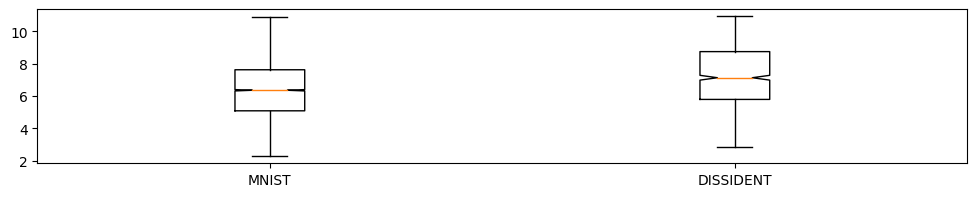

In [ ]:
firings_mnist = {}
firings_mnist['MNIST'] = []
firings_mnist['DISSIDENT'] = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='MNIST HIST'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate_val(data)
        for f, l in  zip(rates, target):
            if l != mnist_class_anomaly:
                firings_mnist['MNIST'].append(f)
            else:
                firings_mnist['DISSIDENT'].append(f)
        

labels, data = firings_mnist.keys(), firings_mnist.values()

fig = plt.figure(figsize =(12, 2))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

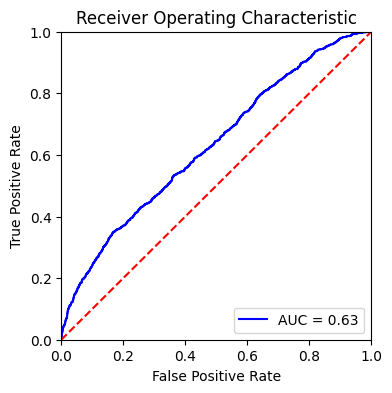

In [ ]:
with torch.no_grad():
    firing_levels = []
    lab_true = []
    lab_pred = []

    for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate_val(data)
        
        for f, l in  zip(rates, lab):
            firing_levels.append(f)
            lab_pred.append(f)        
            if l == mnist_class_anomaly:
                lab_true.append(1)
            else:
                lab_true.append(0)
                    
    fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    fig = plt.figure(figsize =(4, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    writer.add_figure('ROC', fig)

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

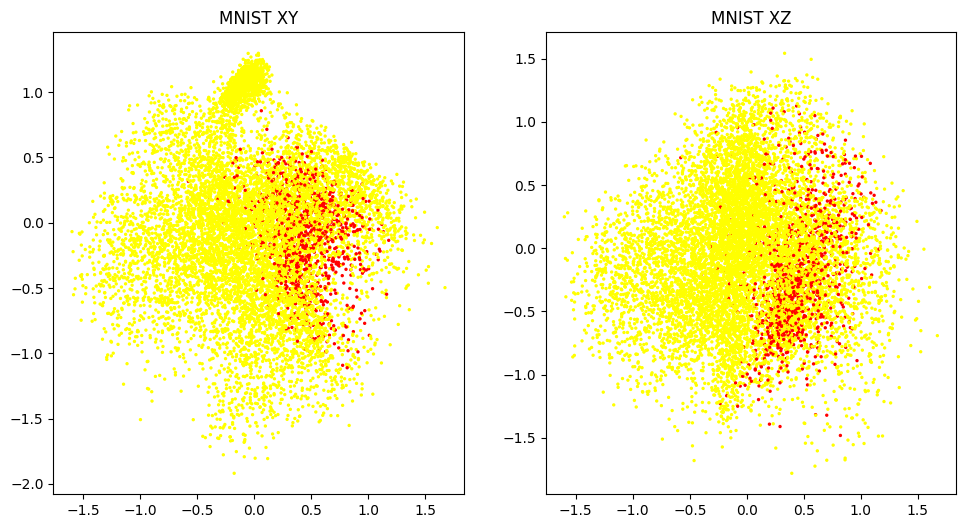

In [ ]:


def show_plot():
    #centroids = model.fuzzy[0].get_centroids().detach().cpu().numpy()
    embedings = []
    labels_expected = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Encoding'):
            data = data.view((-1,1,28,28)).to(device)
            mu,_,_ = fvae.half_pass(data)
            embedings.append(mu.cpu().numpy())
            labels_expected.append((target == mnist_class_anomaly).cpu().numpy())
    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)

    plt.figure(figsize=(18, 6))

    R, C = 1, 3

    plt.subplot(R, C, 1)
    plt.title("MNIST XY")
    
    plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap=binary_cmap, s=2)
    #plt.scatter(centroids[:, 0],      centroids[:, 1], marker='1', c='black', s= 50)

    plt.subplot(R, C, 2)
    plt.title("MNIST XZ")
    plt.scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap=binary_cmap, s=2)
    #plt.scatter(centroids[:, 0],      centroids[:, 2], marker='1', c='black', s= 50)

    
show_plot()

In [ ]:
def show_item_reconstructio(ind):
    for data, trg in iter(test_loader):
        data = data.to(device)
        mu,_,_ = fvae.half_pass(data)
        rec_x = fvae.decoder_pass(mu)
        plt.figure(figsize=(24, 6))

        R, C = 1, 6

        plt.subplot(R, C, 1)
        plt.imshow(data[ind].cpu().squeeze())
        plt.subplot(R, C, 2)
        plt.imshow(rec_x[ind].detach().cpu().squeeze())
        
        plt.subplot(R, C, 3)
        plt.imshow((rec_x[ind] - data[ind]).abs().detach().cpu().squeeze())
        break

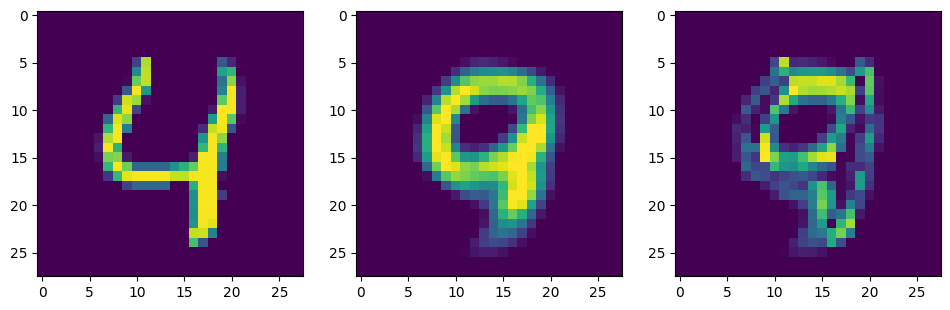

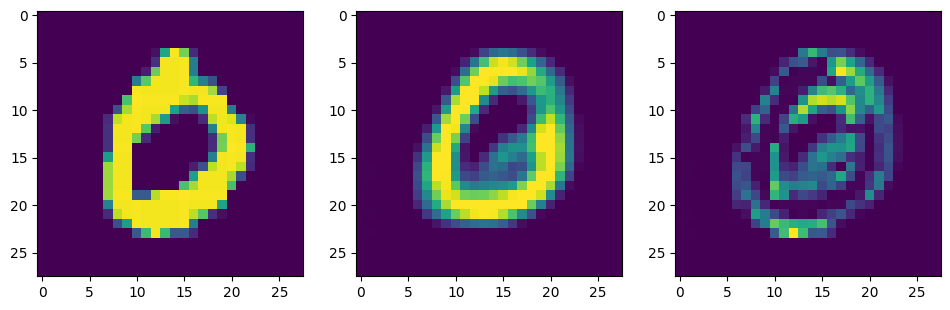

In [ ]:
show_item_reconstructio(4)
show_item_reconstructio(3)

EMNIST VIS:   0%|          | 0/40 [00:00<?, ?it/s]

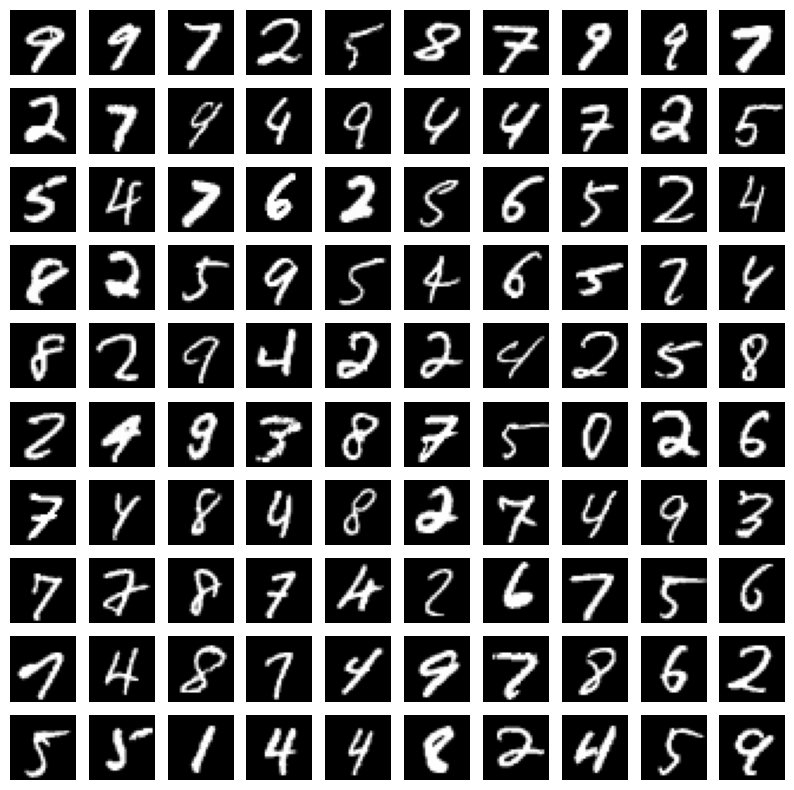

In [ ]:
threshold = optimal_threshold
n = 0
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
with torch.no_grad():
    for data, labels in tqdm(test_loader, desc='EMNIST VIS'):
        if n >= 100:
            break
        data = data.view((-1, 1, 28, 28)).to(device) 
        
        arate = get_arate_val(data)
        
        for i in range(data.shape[0]):
            if(arate[i] > threshold):
                img = data[i]
                ax[int(n / 10), int(n % 10)].imshow(img.view(28, 28).cpu().detach().numpy(), cmap='gray')
                ax[int(n / 10), int(n % 10)].axis('off')
                n = n + 1
                    
                if n >= 100:
                    break